In [571]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from astropy.io import ascii
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astroquery.vizier import Vizier

from astropy.coordinates import GeocentricTrueEcliptic
from astropy.time import Time
import astropy.units as u

import sqlite3

plt.style.use(['ggplot'])
plt.rc("font", size=16)
plt.rc("axes", labelcolor="black")
plt.rc("lines", linewidth=2)
plt.rc("figure", figsize=(10, 6.5))

In [321]:
db = sqlite3.connect("tracklets_testnew.db")

In [322]:
cursor = db.cursor()

In [12]:
field_list = ascii.read("header_object")
field_list['visit_id'] = [int(x.split('/')[0]) for x in field_list['filename']]
field_list['field_id'] = [x.split('V')[0] for x in field_list['value']]
field_list

filename,hdu,keyword,value,visit_id,field_id
str30,int64,str6,str7,int64,str5
0303482/instcal0303482.fits.fz,0,OBJECT,Q5F1V1,303482,Q5F1
0303483/instcal0303483.fits.fz,0,OBJECT,Q5F2V1,303483,Q5F2
0303484/instcal0303484.fits.fz,0,OBJECT,Q5F3V1,303484,Q5F3
0303485/instcal0303485.fits.fz,0,OBJECT,Q5F4V1,303485,Q5F4
0303486/instcal0303486.fits.fz,0,OBJECT,Q5F1V2,303486,Q5F1
0303487/instcal0303487.fits.fz,0,OBJECT,Q5F2V2,303487,Q5F2
0303488/instcal0303488.fits.fz,0,OBJECT,Q5F3V2,303488,Q5F3
0303489/instcal0303489.fits.fz,0,OBJECT,Q5F4V2,303489,Q5F4
0303490/instcal0303490.fits.fz,0,OBJECT,Q5F1V3,303490,Q5F1


In [355]:
ucac_catalogs = {}

for field_name in np.unique(field_list['field_id'])[:20]:
    sel_visit, = np.where(field_list['field_id'] == field_name)
    # sqlite won't cast a numpy.int64 to an int, so have to do it manually    
    visit = int(field_list['visit_id'][sel_visit[0]])
    cursor.execute("SELECT avg(ra), avg(dec) FROM detections WHERE visit = ?", (visit,))
    center_ra, center_dec = cursor.fetchone()
    
    # I/322A = UCAC4
    columns = ['RAJ2000', 'DEJ2000', 'f.mag', 'a.mag']
    vz = Vizier(columns=columns, row_limit=2000)
    ucac_results = vz.query_region(SkyCoord(ra=center_ra, dec=center_dec,
                                                    unit=(u.deg, u.deg), frame='icrs'),
                                     radius=Angle(1.0, "deg"),
                                     catalog='I/322A')

    sel_bright, = np.where(ucac_results[0]['f.mag'] < 14.0)
    ucac_catalog = SkyCoord(ra=ucac_results[0]['RAJ2000'][sel_bright],
                                  dec=ucac_results[0]['DEJ2000'][sel_bright],
                                  unit=(u.deg, u.deg), frame="icrs")
    mags = ucac_results[0]['f.mag'][sel_bright]
    ucac_catalogs[field_name] = (mags, ucac_catalog)


/Users/ctslater/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/ctslater/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/ctslater/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/ctslater/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/ctslater/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/ctslater/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/ctslater/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/ctslater/mini

In [42]:
len(ucac_catalogs[field_name])

154

In [500]:
%%time

bright_star_tracklet_sets = []
tracklet_mean_coords = []
search_box_size = 3.0*u.arcmin

for mags, catalog in ucac_catalogs.values():
    for mag, coord in zip(mags, catalog):

        # Materializing tracklets_4det is much faster than "FROM (SELECT ... WHERE count(*) > 3)"
        cursor.execute("SELECT tl.tracklet, tl.detection, d.ra, d.dec, d.MJD "
                       "FROM tracklets_3det as tr "
                       "JOIN tracklet_links as tl ON tr.tracklet = tl.tracklet "
                       "JOIN detections as d ON tl.detection = d.id "
                       "WHERE d.ra BETWEEN ? AND ? AND d.dec BETWEEN ? and ? ",
                       ((coord.ra - search_box_size).deg,
                        (coord.ra + search_box_size).deg,
                        (coord.dec - search_box_size).deg,
                        (coord.dec + search_box_size).deg))
        nearby_tracklets = cursor.fetchall()
        for tracklet_id in np.unique([x[0] for x in nearby_tracklets]):
            tracklets_ra = np.array([x[2] for x in nearby_tracklets if x[0] == tracklet_id])
            tracklets_dec = np.array([x[3] for x in nearby_tracklets if x[0] == tracklet_id])
            tracklets_mjd = np.array([x[4] for x in nearby_tracklets if x[0] == tracklet_id])
            
            sort_mjd = np.argsort(tracklets_mjd)
            bright_star_tracklet_sets.append((coord, tracklets_ra[sort_mjd], tracklets_dec[sort_mjd], mag, tracklet_id))
            tracklet_mean_coords.append((np.mean(tracklets_ra) - coord.ra.deg,
                                         np.mean(tracklets_dec) - coord.dec.deg))



CPU times: user 8min 7s, sys: 2.44 s, total: 8min 9s
Wall time: 8min 17s


In [350]:
len(bright_star_tracklet_sets)

5252

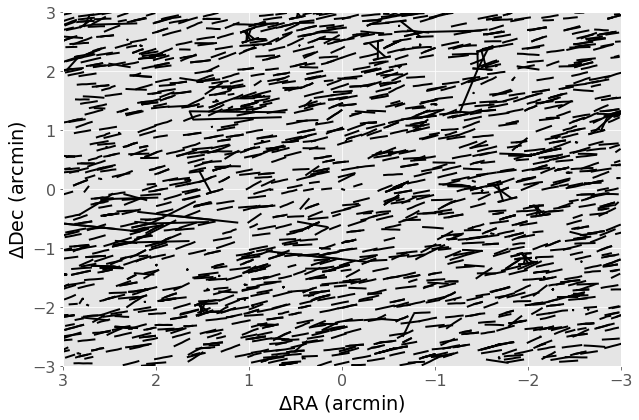

In [501]:

n = 0
group_size = 2000
for coord, tracklets_ra, tracklets_dec, _,_ in bright_star_tracklet_sets[group_size*n:(group_size*(n+1))]:
    delta_ra_arcmin = (tracklets_ra - coord.ra.deg)*60
    delta_dec_arcmin = (tracklets_dec - coord.dec.deg)*60
    plt.plot(delta_ra_arcmin, delta_dec_arcmin, 'k-')
    
box_halfwidth = 3
plt.xlim(box_halfwidth, -box_halfwidth)
plt.ylim(-box_halfwidth, box_halfwidth)

plt.xlabel("$\Delta$RA (arcmin)")
plt.ylabel("$\Delta$Dec (arcmin)")
plt.savefig("stacked_tracklets.pdf")

In [562]:
ecliptic_values = []
for tracklet in bright_star_tracklet_sets[:50]:
    coord = tracklet[0]


    ecliptic_frame = GeocentricTrueEcliptic(equinox=Time(56769.9, format="mjd"))
    coord_ecliptic = coord.transform_to(ecliptic_frame)
    coord_ecliptic = SkyCoord(lon=coord_ecliptic.lon + 1/60.0*u.deg,
                              lat=coord_ecliptic.lat, frame=GeocentricTrueEcliptic)

    ecliptic_PA = coord.position_angle(coord_ecliptic.transform_to("icrs")).deg
    ecliptic_values.append(ecliptic_PA)
    
mean_ecliptic_angle = np.mean(ecliptic_values)

In [502]:
tracklet_angles = []
for tracklet in bright_star_tracklet_sets:
    ra_values = tracklet[1]
    dec_values = tracklet[2]
    if np.sqrt((ra_values[0] - ra_values[-1])**2 +
               (dec_values[0] - dec_values[-1])**2) < 4/3600.0:
        continue

    angle = np.arctan2(ra_values[0] - ra_values[-1],
                       dec_values[0] - dec_values[-1])
    tracklet_angles.append(np.degrees(angle))
    
wrapped_angles = np.array(tracklet_angles)
wrapped_angles += 360 * (wrapped_angles < 0)

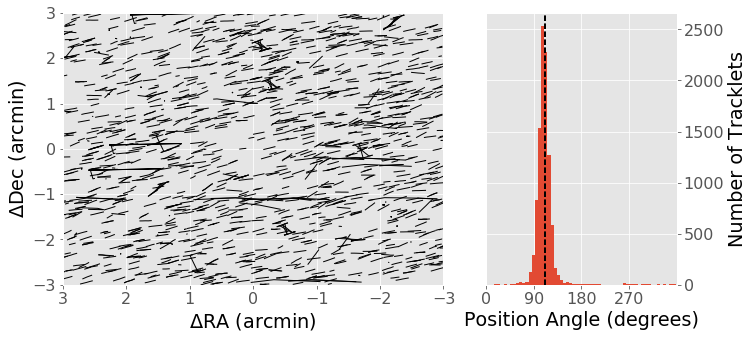

In [600]:
plt.figure(figsize=(11, 5))

gs = gridspec.GridSpec(1, 2, width_ratios=(2,1))

plt.subplot(gs[:, 0])

n = 1
group_size = 1500
for coord, tracklets_ra, tracklets_dec, _,_ in bright_star_tracklet_sets[group_size*n:(group_size*(n+1))]:
    delta_ra_arcmin = (tracklets_ra - coord.ra.deg)*60
    delta_dec_arcmin = (tracklets_dec - coord.dec.deg)*60
    plt.plot(delta_ra_arcmin, delta_dec_arcmin, 'k-', lw=1)
    
box_halfwidth = 3
plt.xlim(box_halfwidth, -box_halfwidth)
plt.ylim(-box_halfwidth, box_halfwidth)

plt.xlabel("$\Delta$RA (arcmin)")
plt.ylabel("$\Delta$Dec (arcmin)")


#plt.subplot(1,2,2)
plt.subplot(gs[:, 1])

_ = plt.hist(wrapped_angles, bins=60)

#plt.axvline(90, ymax=0.5, color='k')
#plt.axvline(270, ymax = 0.5, color='k')
plt.axvline(mean_ecliptic_angle, color='k', ls='--')
plt.xlim(0, 360)
plt.xlabel("Position Angle (degrees)")
plt.ylabel("Number of Tracklets")
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
ax = plt.gca()
plt.xticks([0,90,180,270])
gs.update(hspace=0.15, wspace=0.15)

plt.savefig("stacked_tracklets.pdf")

Locating Bad Subtractions
=========

In [262]:
f = gzip.open("diffims2.o30167.gz")

In [266]:
start_regex = "(\d+) INFO  imageDifferenceDriver.imageDifference: Processing \{\'visit\': (\d+), \'ccdnum\': (\d+)"
tract_regex = "(\d+) .* Using skyMap tract (\d+)"

cpu_current_visitccd = {}
visitccd_tracts = {}
missing_entries = []
n = 0
for line in f:
#    n += 1
    m_start = re.match(start_regex, line.decode('ascii'))
    if m_start:
        proc = int(m_start.group(1))
        visit = int(m_start.group(2))
        ccd = int(m_start.group(3))
        cpu_current_visitccd[proc] = (visit, ccd)
        continue
        
    m_tract = re.search(tract_regex, line.decode('ascii'))
    if m_tract:
        proc = int(m_tract.group(1))
        tract = int(m_tract.group(2))
        if proc in cpu_current_visitccd:
            visitccd_tracts[cpu_current_visitccd[proc]] = tract
        else:
            missing_entries.append((proc, tract))

#    if n > 10000:
#        break

In [268]:
print(len(missing_entries))

80


In [267]:

len(visitccd_tracts)

31000

In [289]:
from collections import defaultdict, Counter
from operator import itemgetter

In [283]:

# Make a dictionary in the form {visit: [tract1, tract, tract3]}
visit_alltracts = defaultdict(list)
for key, tract in visitccd_tracts.items():
    visit, ccd = key
    visit_alltracts[visit].append(tract)
    
# Take the most common tract, assume that's the "correct" one
# Output is now {visit: correct_tract}
visit_maintract = {}
for visit, tracts in visit_alltracts.items():
    c = Counter(tracts)
    visit_maintract[visit] = c.most_common(1)[0][0]

# Find all visit, ccd pairs that reference a different tract
# than the "correct" one.
bad_pairs = []
for key, tract in visitccd_tracts.items():
    visit, ccd = key
    if visit_maintract[visit] != tract:
        bad_pairs.append((visit, ccd))

In [291]:
len(bad_pairs)
ascii.write(([x[0] for x in bad_pairs], [x[1] for x in bad_pairs]), output="bad_pairs.csv", format="csv",overwrite=True)

In [285]:
(303545, 17) in bad_pairs

True